# Introduction to Virtual Sensing and Input Reconstruction
*Created: M.M., 23.5.2024*

In [73]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy import signal
import matplotlib.pyplot as plt

## 1.1. Contineous linear time-invarient (LTI) systems
A linear time-invariant (LTI) system is a collection of first-order linear ordinary differential equations that can be written on a state-space form

\begin{align}
\dot{x}(t) &= Ax(t) + Bu(t)\\
y(t) &= Cx(t),
\end{align}

where $x(k)$ is called the state vector, $u(k)$ the input vector, and $y(k)$ the output or measurement vector. The system is called *linear* because is is a linear operator (meaning that $y = G(u_1+u_2) = Gu_1 + Gu_2$), not to be confused with a line or a plane. Time invariant means that the parameters $A,B,C$ does not change with time.

### Example LTI system
One of the simplest LTI system one can think of might be the sliding cart

![cart](https://raw.githubusercontent.com/mmanngard/VirtualSensors/a079e1fe01148c749caa5fd2745499da8c11a760/notebooks/cart.drawio.svg)

where $\mu$ is a friction coefficient, and $F$ is a force applied to the cart.

It is surprising how often this simple school book example can be used to approximate real-world systems! Newton's laws of motion with (net force $F$ equals mass $m$ times acceleration $\ddot{x}$) gives
\begin{equation*}
m\ddot{x} = F - \mu\dot{x},
\end{equation*}
which is a second-order differential equation. This can be rewritten as a set of first-order differential equation by defining new states:
- Position: $x_1=x$
- Velocity: $x_2=\dot{x}$,

and input:

- Net force: $u=F$.

Rewriting the system gives

$$
\begin{bmatrix}
\dot{x}_1\\
\dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
0 &1\\
0 &-\mu/m
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0\\1/m
\end{bmatrix}
u.
$$

Suppose we measure the velocity of the cart, we have
$$
y = \begin{bmatrix}
0 &1
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
+v
$$
where $v$ is measurement noise. This is exacly of the form (1)-(2).

### Simulate LTI systems

Text(0.5, 0, 'time (s)')

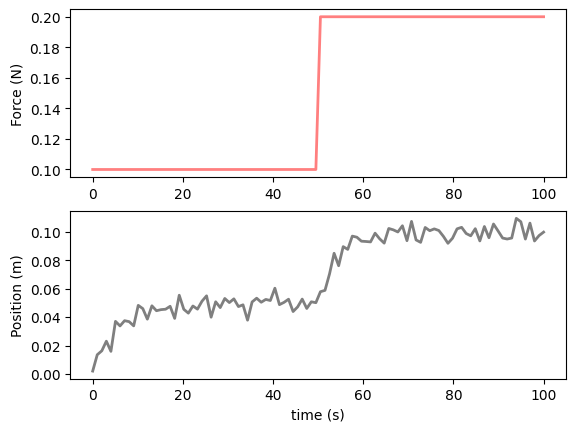

In [74]:
# parameters
mu = 2 #friction coefficient
m = 10 #mass

# system matrices
A = np.array([[0, 1],[0, -mu/m]])
B = np.array([[0],[1/m]])
C = np.array([[0, 1]])

# simulaiton parameters
N = 100 #number of time steps
t = np.linspace(0,100,N) #time points
#input signal (step)
u = np.array([])
for i in range(N):
    if i<N/2:
        u = np.append(u,.1)
    else:
        u = np.append(u,.2)

# measurement noise
v = 0.005*np.random.normal(0,1,N)

# simulate
sys = signal.StateSpace(A,B,C)
tout, y, xout = signal.lsim(sys, U=u, T=t)
# add noise
y += v

# plot result
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'r', alpha=0.5, linewidth=2, label='input')
axs[0].set_ylabel('Force (N)')
axs[1].plot(tout, y,'k', alpha=0.5, linewidth=2, label='position')
axs[1].set_ylabel('Position (m)')
plt.xlabel('time (s)')


## Reconstructing unknown input signals
Consider now the previous cart example where we have collecter measurements $y(0), y(1),...,(N-1)$ and want to reconstruct the force applied to it. Using the `c2d()` function we can convert the continuous-time model to a discrete-time state space model
\begin{align*}
x(k+1) &= Ax(k) + Bu(k)\\
y(k) &= Cx(k) + v(k).
\end{align*}
Note that the $A,B,C$ matrices are now different from in the previous section and $y(k)$ is a measurement obtaind at the $k$ th time instance.

In [75]:
def c2d(A,B,Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m,n = A.shape
    m,nb = B.shape

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate( [s, np.zeros( (nb,n+nb) )],axis=0 )
    S = expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    return Ad, Bd



### The data equation
After substituting the first equation int the second equation repeated times, and after some algebraic manipulations, we get the so called **data equation**

$$
\begin{aligned}
    y(0) &= Cx(0) + v(0),\\
    y(1) &= CAx(0) + Bu(0) + v(1),\\
    \vdots &\\
    y(n) &= CA^{n}x(0) + \sum_{k=0}^{n-1} CA^{k}u(n-k-1) + v(n),\\
    \vdots &
\end{aligned}
$$

or in matrix form

$$
\underbrace{
\begin{bmatrix}
y(0)\\
y(1)\\
y(2)\\
\vdots\\
y(N-1)
\end{bmatrix}
}_{y}
=
\underbrace{
\begin{bmatrix}
C\\
CA\\
CA^2\\
\vdots\\
CA^{N-1}
\end{bmatrix}
}_{\mathcal{O}}
x(0)
+
\underbrace{
\begin{bmatrix}
0 &0 &\cdots &0\\
CB &0 &\cdots &0\\
CAB &CB &\cdots &0\\
\vdots &\vdots &\ddots &\vdots\\
CA^{N-2}B &CA^{N-3}B &\cdots &0
\end{bmatrix}
}_{\Gamma}
\underbrace{
\begin{bmatrix}
u(0)\\u(1)\\u(2)\\ \vdots\\ u(N-1)
\end{bmatrix}
}_{u}
+
\underbrace{
\begin{bmatrix}
v(0)\\v(1)\\v(2)\\ \vdots\\ v(N-1)
\end{bmatrix}
}_{v}.
$$

The section on *subspace system identification* in the book [Filtering and System Identification](https://books.google.fi/books?hl=sv&lr=&id=6Ne76uYOlVwC&oi=fnd&pg=PR11&dq=verhaegen+least+squares+approach&ots=H7GzIs_Rab&sig=PfKVrPuYiSlWfjI3_tymLiI1-U8&redir_esc=y#v=onepage&q=verhaegen%20least%20squares%20approach&f=false) by Verhaegen, Michel, and Vincent Verdult explains this well (*read*: check that I havent done any mistakes here).

* **Note**: This equation is commonly occuring in the control-theory and system identification litterature and is often referred to as the *data equation*. Here I have used the standard notation $\mathcal{O}$ for the extended observability matrix (which is used for determining stability of a system), and $\Gamma$ for the impulse response matrix. The impulse response of the system is $h(k) = CA^{k-1}B$. In [(Ikonen et al.,2015)](https://www.sciencedirect.com/science/article/pii/S0165232X14002274), the non-standard notation  $g(k)=h(k)$, $R=y$, $G = \Gamma$, and $M = u$ was used instead.


In [76]:
def obsv(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    O = C
    for k in range(1, n):
        O = np.vstack((O, C @ np.linalg.matrix_power(A, k)))

    return O

# I got some errors with your function, so I modified the solution I found from stackexchange:
# https://scicomp.stackexchange.com/questions/33239/is-there-an-efficient-way-to-form-this-block-matrix-with-numpy-or-scipy

def Gamma(A,B,C,N):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    mat_list = []
    n = (C@B).shape[0]
    m = (C@B).shape[1]
    for i in range(N): # generate row
        tmp = []
        for j in range(N): # loop through A^j*B
            if j <= i:
                tmp.append(C@np.linalg.matrix_power(A,i-j)@B)
        if i < N-1:
            tmp.append(np.zeros((n, m*(N-1-i))))
        mat_list.append(tmp)
        G = np.block(mat_list)
        #add zero row and column
        n,m = (C@B).shape
        ng,mg = G.shape
        G = np.append(np.zeros((n,mg)),G,axis=0)
        G = np.append(G,np.zeros((n+ng,m)),axis=1)
    return G

### The reconstruction problem
Assume for simplicity that we know the initial state $x(0)=0$, we have
$$
y = \Gamma u + v
$$
and we would like to find the vector $u$ that minimizes the error $y - \Gamma u$. The reconstruction problem can thus be solved as a **linear least-squares-type problem**. Typically, however, to ensure that the problem is well-posed and to reduce the sensitivity to measurement noise, a **regularized least-squares problem** is solved instead.

$$
\underset{u}{\mathrm{minimize}} || y - \Gamma u ||^2_2 + R(u),
$$

where $R(u)$ is a regularization function. Deciding what function $R$ to use is an engineering problem, and the choice depends completely on experience and the prior knowledge of the signal $u$. Various types of regularization functions were proposed in ([Urho Hakonen, 2023](https://aaltodoc.aalto.fi/items/2cb62532-ea16-48b2-ace1-0a7bfcd4f947)), for example
- **Tikhonov regularization** $R(u)=\|u\|_2^2$ (also called Ridge regression). Tikhonov-regularization seems to be a reasonable choice when $u$ is a zero-mean stationary-stochastic signal.
- **Hodrick-Prescott trend filtering** $R(u)=\|\Delta^2 u\|_2^2$ (enforces smoothness on $u$). A natural choice for estimation of physical signals such as force and moment since such tend to be smooth signals in nature.

#### Tikhonov regularization
Consider the Tikhonov regularized input-reconstruction problem minimizing the cost function.
$$
J(u) = || y - \Gamma u ||^2_2 + \lambda||u||_2^2,
$$
Where $\lambda$ is a regularization parameter. The Rikhonov regularized problem has a solution
$$
\hat{u} = ( \Gamma^T\Gamma + \lambda I )^{-1}\Gamma^T y.
$$
*This can be verified by noting that $J$ is a quadratic function which has its minimum at $\frac{\mathrm{d}J}{du}=0$.*

Text(0.5, 0, 'time (s)')

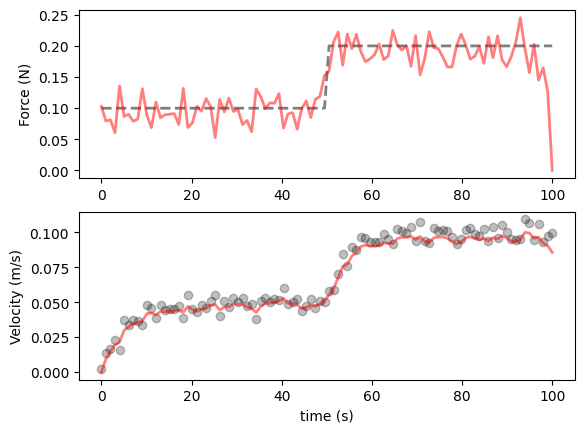

In [95]:
# discrete-time system
A, B = c2d(sys.A,sys.B,1)

# Compute Gamma
G = Gamma(A,B,C,N-1)

lam = 0.01

# Estimate u
uhat = np.linalg.pinv(G.T@G + lam*np.eye(N))@G.T@np.reshape(y,(N,1))

# plot results
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'k--', alpha=0.5, linewidth=2, label='input')
axs[0].plot(t, uhat,'r', alpha=0.5, linewidth=2, label='Tikhonov estimate')
axs[0].set_ylabel('Force (N)')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None)
axs[1].plot(tout, G @ uhat,'r', alpha=0.5, linewidth=2, label='position')
axs[1].set_ylabel('Velocity (m/s)')
plt.xlabel('time (s)')

### Hodrick-Prescott trend filtering
In H-P filtering, the regularization term minimizes the $\ell_2$ norm of the second difference $u(k-1) - 2u(k) + u(k+1)$. If the second difference of a signal is small, the signal is smooth. The H-P trend filtering input reconstruction problem is
$$
\underset{u}{\mathrm{minimize}}~ || y - \Gamma u ||^2_2 + \lambda \| \Delta_2 u \|_2^2  .
$$
where
\begin{equation}
    \Delta_2 =
    \begin{bmatrix}
    1 &-2 &1      &       &       & \\
      &1  &-2     &1      &       & \\
      &   &\ddots &\ddots &\ddots & \\
      &   &       &1      &-2     &1
    \end{bmatrix}
\end{equation}
and has the solution
$$
\hat{u} = ( \Gamma^2\Gamma + \lambda\Delta_2^{T}\Delta_2 )^{-1}\Gamma^Ty
$$



Text(0.5, 0, 'time (s)')

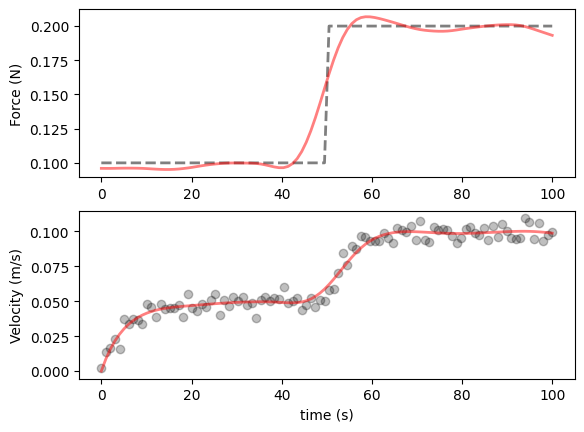

In [94]:
Delta = np.eye(N,k=-1) - 2*np.eye(N) + np.eye(N,k=1)
Delta[0,:] = 0
Delta[-1,:] = 0

#H-P estimate
lam = 10
uhat_HP = np.linalg.inv(G.T@G + lam*Delta.T@Delta)@G.T@np.reshape(y,(N,1))

# plot results
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'k--', alpha=0.5, linewidth=2, label='input')
axs[0].plot(t, uhat_HP,'r', alpha=0.5, linewidth=2, label='H-P estimate')
axs[0].set_ylabel('Force (N)')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None)
axs[1].plot(tout, G @ uhat_HP,'r', alpha=0.5, linewidth=2, label='position')
axs[1].set_ylabel('Velocity (m/s)')
plt.xlabel('time (s)')

## H-P filtering with additional constraints
In this section, we illustrate how constraints on the input signals can be added and solved as a convex optimization problem with `cvxpy`. Assume we want to enforce bound on the estimated output $\hat{y}(k) = \Gamma \hat{u}$, i.e.,
$$
| y - \Gamma \hat{u} | \leq \varepsilon,
$$
where $\varepsilon > 0$. This results in the convex optimizaiton problem
\begin{align*}
    &\underset{u}{\mathrm{minimize}}~ || y - \Gamma u ||^2_2 + \lambda \| \Delta_2 u \|_2^2 \\
    &\text{subject~to} \\
    &|y - \Gamma \hat{u}| \leq \varepsilon 
\end{align*}

The follopwing example code shows how the problem is implemented in `cvxpy`.

0.004659769907106711


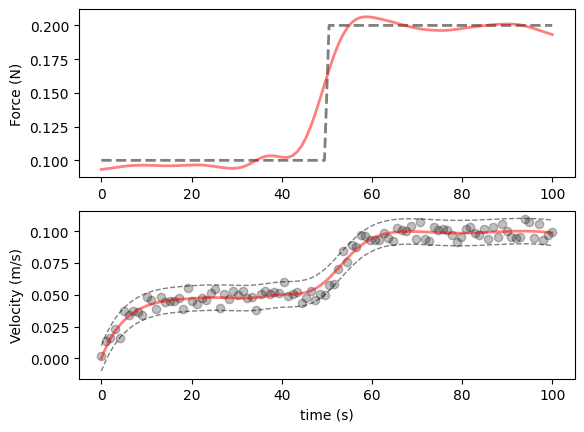

In [90]:
import cvxpy as cp

# create bounds
eps = 0.01
ub = u + eps
lb = u - eps
lam = 10

# define optimization variables
uhat_cvx = cp.Variable(N, complex=False)

# define objective function
objective = cp.Minimize(cp.sum_squares(y - G @ uhat_cvx) + lam * cp.sum_squares(Delta @ uhat_cvx))

# define constraints
constraints = [
    cp.abs( y - G @ uhat_cvx ) <= eps
]

# define problem
prob = cp.Problem(objective, constraints)

# solve optimizaiton problem
prob.solve()

# plot results
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'k--', alpha=0.5, linewidth=2, label='input')
axs[0].plot(t, uhat_cvx.value,'r', alpha=0.5, linewidth=2, label='H-P CVX estimate')
axs[0].set_ylabel('Force (N)')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None)
axs[1].plot(tout, G @ uhat_cvx.value,'r', alpha=0.5, linewidth=2, label='position')
axs[1].plot(tout, G @ uhat_cvx.value + eps,'k--', alpha=0.5, linewidth=1, label='position')
axs[1].plot(tout, G @ uhat_cvx.value - eps,'k--', alpha=0.5, linewidth=1, label='position')
axs[1].set_ylabel('Velocity (m/s)')
plt.xlabel('time (s)')
